In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from model import model
from random import random, choice, randint
from numpy import copy
import operator

In [2]:
# Importing the dataset
dataset = pd.read_csv('Social_Network_Ads.csv')
X = dataset.iloc[:, [2, 3]].values
y = dataset.iloc[:, 4].values

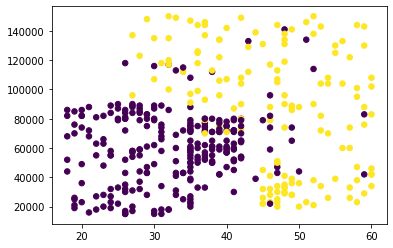

In [3]:
#visualize
plt.scatter(X[:, 0], X[:, 1], c = y, s= 30)
plt.show()

In [4]:
#split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

#Scale the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# adding the column of ones in X for the bias term
X_train = np.concatenate((np.ones((X_train.shape[0], 1)), X_train), axis = 1)
X_test = np.concatenate((np.ones((X_test.shape[0], 1)), X_test), axis = 1)

# hyperparameters
nb_hdn_neurons = 8
nb_output_neurons = 1 #binary classification
input_size = 3 #including bias
W1_shape = (8, 3)
W2_shape = (1, 9)
initial_population_size = 50
# total parameters = 8*3 + 9*1 = 33


population = [] #the very first population

In [5]:
def initialize_population():
    #convention: each chromosome will have dimensions 1x33
    for i in range(initial_population_size):
        W1 = np.random.randn(W1_shape[0], W1_shape[1])
        W2 = np.random.randn(W2_shape[0], W2_shape[1])
        population.append(np.concatenate((W1.flatten().reshape(1,W1_shape[0]*W1_shape[1] ), W2.flatten().reshape(1,W2_shape[0]*W2_shape[1] )),axis = 1))

def get_weights_from_encoded(individual):
    W1 = individual[:, 0:W1_shape[0]*W1_shape[1]]
    W2 = individual[:, W1_shape[0]*W1_shape[1]:]
    return (W1.reshape(W1_shape[0], W1_shape[1]), W2.reshape(W2_shape[0], W2_shape[1]))

def generate_random_chromosome():
    W1 = np.random.randn(W1_shape[0], W1_shape[1])
    W2 = np.random.randn(W2_shape[0], W2_shape[1])
    return np.concatenate((W1.flatten().reshape(1,W1_shape[0]*W1_shape[1] ), W2.flatten().reshape(1,W2_shape[0]*W2_shape[1] )),axis = 1)
    

def get_losses(population): #The rank function
    losses = []
    for individual in population:
        mdl = model(get_weights_from_encoded(individual))
        losses.append(mdl.loss(X_train, y_train))
    zip1 = zip(losses,population)
    sorted_results = sorted(zip1, key=operator.itemgetter(0))
    sorted_pop = [x for _,x in sorted_results]
    sorted_losses = [_ for _,x in sorted_results]
    return sorted_pop, sorted_losses



def mutate(chromosome, prob):
    if random() >= prob:
        return chromosome, False # No mutation done
    else:
        #mutate each element with a probability of 'prob'
        mutated = False
        chromosome0 = copy(chromosome)
        operators = ['add', 'subtract']
        for i in range(len(chromosome0)):
            if random() < prob:
                if choice(operators) == 'add':
                    chromosome0[i] += random()
                    mutated = True
                else:
                    chromosome0[i] -= random()
                    mutated = True
        return chromosome0, mutated # mutated
    

def crossover(chromosomes, prob):
    # here the argument chromosomes is a list containing two parent chromosomes
    if random() >= prob:
        return chromosomes, False # No crossover done
    else:
        #select a random position from the index, around which the values will be swapped
        indx = randint(1, chromosomes[0].shape[1]-1)
        p0 = copy(chromosomes[0]); p1 = copy(chromosomes[1])
        med = copy(p0)
        p0[:, 0:indx] = p1[:, 0:indx]
        p1[:, 0:indx] = med[:, 0:indx]
        return [p0, p1], True
    

def crossover2(chromosomes, prob):
    # here the argument chromosomes is a list containing two parent chromosomes
    #for every index along the length of both chromosomes, randomly select if it has to be swapped
    p0 = copy(chromosomes[0]); p1 = copy(chromosomes[1])
    crossovered = False
    for i in range(chromosomes[0].shape[1]):
        if random() < prob:
            #swap the numbers at index i
            p0[0, i] = chromosomes[1][0][i]
            p1[0, i] = chromosomes[0][0][i]
            crossovered = True
    return [p0, p1], crossovered


def selectindex():
    return randint(0, 10) #including the 11th element


def evolve(initial_population ,max_iter = 20,min_desired_loss = None, crossover_prob = 0.7, mutation_prob = 0.2, crossover2_prob = 0.2):
    population = initial_population
    for iteration in range(max_iter):
        # create population, 
        # breed, mutate, and keep the 5 best to the next generation unchanged for next generation
        if iteration % 100 == 0 or iteration == max_iter-1: print("Generation ", iteration)
        newpop = []
        sorted_pop, sorted_losses = get_losses(population)
        if iteration % 100 == 0 or iteration == max_iter-1: print("loss = ",sorted_losses[0])
        if min_desired_loss is not None:
            if sorted_losses[0] <= min_desired_loss:
                return sorted_losses[0], population[0]
        # The top five always make it:
        newpop.append(sorted_pop[0]); newpop.append( sorted_pop[1]);newpop.append( sorted_pop[2])
        newpop.append( sorted_pop[3]);newpop.append( sorted_pop[4])
        while len(newpop) < initial_population_size:
                # select any from the top 10 of the population and randomly breed and mutate them
                # First crossover:
                idx1 = selectindex();idx2 = selectindex()
                if idx1 != idx2:
                    children, crossovered = crossover([population[idx1],population[idx2]], prob = crossover_prob)
                    if crossovered and len(newpop) < initial_population_size-1:
                        newpop.extend(children)
                # Mutation:
                idx1 = selectindex()
                child, mutated = mutate(population[idx1], prob = mutation_prob)
                if mutated and len(newpop) < initial_population_size:
                    newpop.append(child)
                # Crossover 2:
                idx1 = selectindex();idx2 = selectindex()
                if idx1 != idx2:
                    children, crossovered = crossover2([population[idx1],population[idx2]], prob = crossover2_prob)
                    if crossovered and len(newpop) < initial_population_size-1:
                        newpop.extend(children)
                #add a random new chromosome by the probability of none of the above hapening
                prob_none =1- ((crossover_prob*(1-mutation_prob)*(1-crossover2_prob) + (1-crossover_prob)*(mutation_prob)*(1-crossover2_prob)+(1-crossover_prob)*(1-mutation_prob)*(crossover2_prob))
                           +(crossover_prob*mutation_prob*(1-crossover2_prob) + (1-crossover_prob)*mutation_prob*crossover2_prob + crossover_prob*(1-mutation_prob)*crossover2_prob)
                           +crossover_prob*mutation_prob*crossover2_prob )
                if random() < prob_none and len(newpop) < initial_population_size:
                    newpop.append(generate_random_chromosome())
        population = list(np.copy(newpop))
    sorted_pop, sorted_losses = get_losses(population)
    return sorted_losses[0], sorted_pop[0]

In [6]:
initialize_population()
loss, weights = evolve(population ,max_iter = 1000,min_desired_loss = 0.2000, crossover_prob = 0.7, mutation_prob = 0.2, crossover2_prob = 0.2)
weights = get_weights_from_encoded(weights)

Generation  0
loss =  0.6370457163864132


/home/reaper/Projects/GA_experiment/model.py:29: RuntimeWarning: divide by zero encountered in log
  loss = y*np.log(y_pred) + (1 - y)*(np.log(1 - y_pred))
/home/reaper/Projects/GA_experiment/model.py:29: RuntimeWarning: invalid value encountered in multiply
  loss = y*np.log(y_pred) + (1 - y)*(np.log(1 - y_pred))


Generation  100
loss =  0.263465662845748
Generation  200
loss =  0.2352298613970314
Generation  300
loss =  0.23439461989444266
Generation  400
loss =  0.23356503447465612
Generation  500
loss =  0.23208100549904787
Generation  600
loss =  0.23077618343032552
Generation  700
loss =  0.2300501361290836
Generation  800
loss =  0.22941286309000467
Generation  900
loss =  0.22905616165172696
Generation  999
loss =  0.22701150653689334


In [7]:
#Checking accuracy by plotting
model = model(weights)
#Training accuracy:
y_pred_train = model.forward_propagate(X_train)
for i in range(y_pred_train.shape[1]):
    if y_pred_train[0][i] >= 0.5:
        y_pred_train[0][i] = 1
    else:
        y_pred_train[0][i] = 0
        
y_pred_train = y_pred_train.reshape((320,))
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, y_pred_train)
accuracy_train = (cm[0][0]+cm[1][1])/np.sum(cm)
print("training accuracy = ",accuracy_train)

#Test accuracy:
y_pred_test = model.forward_propagate(X_test)
for i in range(y_pred_test.shape[1]):
    if y_pred_test[0][i] >= 0.5:
        y_pred_test[0][i] = 1
    else:
        y_pred_test[0][i] = 0
        
y_pred_test = y_pred_test.reshape((80,))
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_test)
print(cm)

accuracy_test = (cm[0][0]+cm[1][1])/np.sum(cm)
print("test accuracy = ",accuracy_test)

training accuracy =  0.903125
[[47  5]
 [ 3 25]]
test accuracy =  0.9


In [8]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from sklearn.preprocessing import StandardScaler
import numpy as np

#split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

#Scale the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#Train a neural net without any regularization first
nb_hdn_neurons = 8
nb_output_neurons = 1 #binary classification
nb_features = 2

def get_model():
    model = Sequential()
    model.add(Dense(output_dim = nb_hdn_neurons, init = 'uniform', activation = 'relu', input_dim = nb_features))
    model.add(Dense(output_dim = nb_output_neurons, init = 'uniform', activation = 'sigmoid', kernel_regularizer=regularizers.l2(0.2)))
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model


def train_nn():
    model = get_model()
    history = model.fit(X_train,y_train, batch_size=32,validation_data=(X_test, y_test), epochs=1000,verbose=0, 
                        #validation_split=0.1
                        )
    return history, model

#training with backprop
history, model = train_nn()

y_pred0 = model.predict_classes(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm0 = confusion_matrix(y_test, y_pred0)
print(cm0)

accuracy_test0 = (cm0[0][0]+cm0[1][1])/np.sum(cm0)
print("test accuracy = ",accuracy_test0)

Using TensorFlow backend.
/home/reaper/anaconda3/envs/dl/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/reaper/anaconda3/envs/dl/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/reaper/anaconda3/envs/dl/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/reaper/anaconda3/envs/dl/l






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/reaper/anaconda3/envs/dl/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/reaper/anaconda3/envs/dl/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/reaper/anaconda3/envs/dl/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/reaper/anaconda3/envs/dl/lib/py


[[49  4]
 [ 9 18]]
test accuracy =  0.8375
